# Inicio de modelos

In [ ]:
import joblib
import seaborn                     as     sns
from sklearn.metrics               import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.model_selection       import train_test_split
import numpy                       as     np
import pandas                      as     pd
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot           as     plt
from skopt                         import BayesSearchCV
from sklearn.preprocessing         import MinMaxScaler
from sklearn.linear_model          import LinearRegression
from sklearn.metrics               import r2_score
from sklearn.model_selection       import cross_val_score
from sklearn.preprocessing         import StandardScaler
from sklearn.pipeline              import Pipeline
from sklearn.preprocessing         import MinMaxScaler
import statsmodels.api             as     sm
from IPython.display               import display
from statsmodels.stats.diagnostic  import acorr_ljungbox
from scipy.stats                   import jarque_bera
from sklearn.model_selection       import train_test_split
from sklearn.model_selection       import GridSearchCV
from sklearn                       import neighbors
from sklearn.metrics               import explained_variance_score
from sklearn.neighbors             import KNeighborsRegressor
from sklearn.linear_model          import LinearRegression
from sklearn.linear_model          import Ridge
from sklearn.linear_model          import Lasso
import mglearn
import plotly.express              as     px
from typing                        import Tuple, List, Any
sns.set_style("whitegrid")

In [ ]:
holt = pd.read_excel('for_Holt.xlsx')

In [ ]:
holt = holt.drop(['Codigo_Dpto', 'Nro_Grupos_40', 'Nro_Grupos_30', 'Nro_Grupos_25'],axis='columns')


In [ ]:
class data_model :
  def __init__(self, data, test_period):
    X_train =  data[data['Periodo']<test_period].drop(['Demanda_Max_Estimada','Titulo_Curso'], axis='columns').reset_index(drop=True)
    X_test  =  data[data['Periodo']==test_period].drop(['Demanda_Max_Estimada','Titulo_Curso'], axis='columns').reset_index(drop=True)
    y_train =  pd.DataFrame(data[data['Periodo']<test_period]['Demanda_Max_Estimada'].reset_index(drop=True))
    y_test  =  pd.DataFrame(data[data['Periodo']==test_period]['Demanda_Max_Estimada'].reset_index(drop=True))
    self.X_train = X_train
    self.X_test  = X_test
    self.y_train = y_train
    self.y_test  = y_test
def calcular_metricas(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    lst = []
    for i in range(len(y_true)):
      if y_true[i] != 0:
        num = (y_true[i]-y_pred[i])/y_true[i]
        lst.append(num)
    mape = np.mean(lst) * 100
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    lb_test = acorr_ljungbox(y_true - y_pred, lags=[10], return_df=True)
    ljung_box_p_value = lb_test['lb_pvalue'].iloc[0]
    jb_test = jarque_bera(y_true - y_pred)
    jarque_bera_p_value = jb_test[1]
    return {'RMSE': [rmse], 'MAPE': [mape], 'R2': [r2], 'Ljung-Box p-value': [ljung_box_p_value],'Jarque-Bera p-value': [jarque_bera_p_value]}
def get_len(df, index):
  if index + 2 >= len(df):
        return 0
  periodo = df.iloc[index+2]['Periodo']
  return len(df[df['Periodo']==periodo])

def training(*, data, parameters, regressor):
  best_model = None
  best_score = 10000
  for parameter in parameters:
      if regressor == 'linear':
        reg = LinearRegression()
      elif regressor == 'knn':
        reg = KNeighborsRegressor(n_neighbors = parameter)
      index = 0
      while index < len(data.X_train):
        len_train = get_len(data.X_train, index)
        xtrain = (data.X_train[index:index+ len_train]).drop('Periodo',axis='columns')
        ytrain = (data.y_train[index:index+ len_train])
        if len(xtrain)>0 and len(ytrain)>0 :
          reg.fit(xtrain, ytrain)
        index += len_train
      predicted = reg.predict(data.X_test.drop('Periodo',axis='columns'))
      rmse = np.sqrt(np.mean((data.y_test - predicted) ** 2))
      if rmse      < best_score:
        best_score = rmse
        best_model =  reg
  return best_model

In [ ]:
mayores = data_model(holt[holt['Demanda_Max_Estimada']>40],202410)
menores = data_model(holt[holt['Demanda_Max_Estimada']<=40],202410)

# Knn

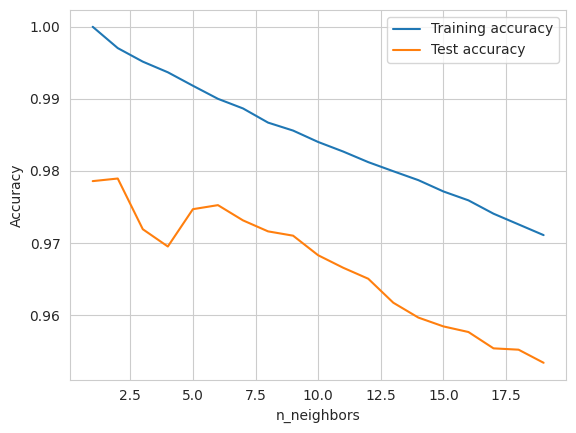

,Best cross-validation accuracy:,Best parameters:
0,0.989296,{'n_neighbors': 1}


In [ ]:
training_accuracy = []
test_accuracy = []
best_score = 0
tuple_scores = None
neighbors_settings = range(1, 20)
for n_neighbors in neighbors_settings:
    knn =KNeighborsRegressor(n_neighbors=n_neighbors)
    knn.fit(mayores.X_train, mayores.y_train)
    training_accuracy.append(knn.score(mayores.X_train, mayores.y_train))
    test_accuracy.append(knn.score(mayores.X_test, mayores.y_test))
    scores = [(knn.score(mayores.X_train, mayores.y_train)), knn.score(mayores.X_test, mayores.y_test) ]
    score = np.mean(scores)
    if score > best_score :
        best_score = score

        best_parameters = {'n_neighbors': n_neighbors}
plt.plot(neighbors_settings, training_accuracy, label="Training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="Test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend( )
dx = {}
dx["Best cross-validation accuracy:"] = [best_score]
dx["Best parameters:"] = [best_parameters]
plt.show()
pd.DataFrame(dx)

In [ ]:
knn =KNeighborsRegressor(n_neighbors=1)
knn.fit(mayores.X_train.drop('Periodo',axis='columns'), mayores.y_train)
pred = knn.predict(mayores.X_test.drop('Periodo',axis='columns'))
pd.DataFrame(calcular_metricas(mayores.y_test, pred))

,RMSE,MAPE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,23.179689,0.534596,0.981922,1.291238e-10,0.0


<ipython-input-16-235fe0764c91>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sub.append(float(pred[0]))


Text(0.5, 1.0, 'Residuos')

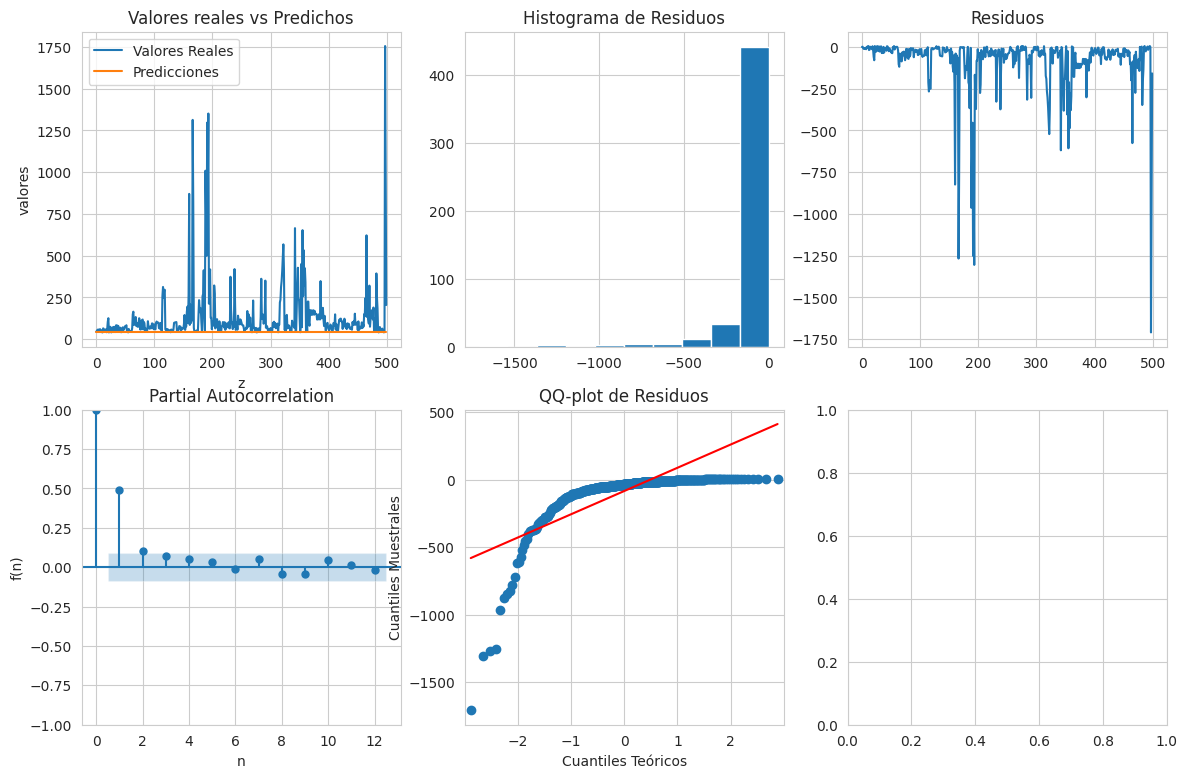

In [ ]:
fig,ax=plt.subplots(2,3);fig.set_size_inches(14,9);

sub = []
for i in pred:
  sub.append(float(pred[0]))

pred = sub


y1 = list(pred); y2 = list(mayores.y_test['Demanda_Max_Estimada']);
residuos_knn = [ ]
for index,(uno, dos) in enumerate(zip(y1, y2)):
      residuos_knn.append(uno - dos)
data = pd.DataFrame({
    'Predicciones': y1,
    'Valores Reales': y2,
    'residuos': residuos_knn
})
ax[0][0].set_title('Valores reales vs Predichos')
ax[0][0].plot(data[ 'Valores Reales'],'-')
ax[0][0].plot(data['Predicciones'],'-')
ax[0][0].legend(['Valores Reales', 'Predicciones'])
ax[0][0].set_ylabel('valores')
ax[0][0].set_xlabel('z')
plot_pacf(residuos_knn, lags=12, ax=ax[1][0])
ax[1][0].set_ylabel('f(n)')
ax[1][0].set_xlabel('n')
ax[0][1].set_title('Histograma de Residuos')
ax[0][1].hist(data['residuos'])
sm.qqplot(data['residuos'], line='s', ax=ax[1][1])
ax[1][1].set_title('QQ-plot de Residuos')
ax[1][1].set_xlabel('Cuantiles Teóricos')
ax[1][1].set_ylabel('Cuantiles Muestrales')
ax[0][2].plot(data['residuos'])
ax[0][2].set_title('Residuos')

### Entrenamiento por periodo

In [ ]:
knn = training( data = mayores, parameters = [1], regressor = 'knn')
pred = knn.predict(mayores.X_test.drop('Periodo',axis='columns'))
pd.DataFrame(calcular_metricas(mayores.y_test, pred))

,RMSE,MAPE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,49.603508,1.519507,0.917215,6.406942e-09,0.0


Text(0.5, 1.0, 'Residuos')

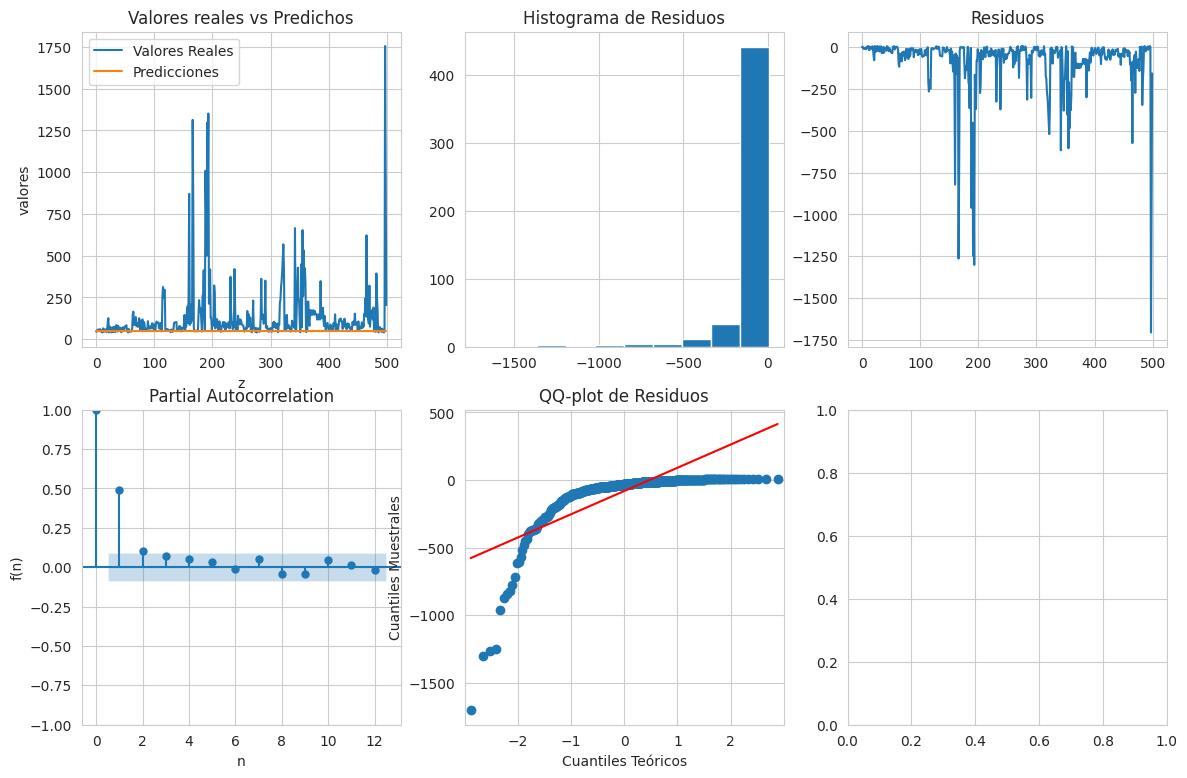

In [ ]:
fig,ax=plt.subplots(2,3);fig.set_size_inches(14,9);

sub = []
for i in pred:
  sub.append(float(pred[0]))

pred = sub


y1 = list(pred); y2 = list(mayores.y_test['Demanda_Max_Estimada']);
residuos_knn = [ ]
for index,(uno, dos) in enumerate(zip(y1, y2)):
      residuos_knn.append(uno - dos)
data = pd.DataFrame({
    'Predicciones': y1,
    'Valores Reales': y2,
    'residuos': residuos_knn
})
ax[0][0].set_title('Valores reales vs Predichos')
ax[0][0].plot(data[ 'Valores Reales'],'-')
ax[0][0].plot(data['Predicciones'],'-')
ax[0][0].legend(['Valores Reales', 'Predicciones'])
ax[0][0].set_ylabel('valores')
ax[0][0].set_xlabel('z')
plot_pacf(residuos_knn, lags=12, ax=ax[1][0])
ax[1][0].set_ylabel('f(n)')
ax[1][0].set_xlabel('n')
ax[0][1].set_title('Histograma de Residuos')
ax[0][1].hist(data['residuos'])
sm.qqplot(data['residuos'], line='s', ax=ax[1][1])
ax[1][1].set_title('QQ-plot de Residuos')
ax[1][1].set_xlabel('Cuantiles Teóricos')
ax[1][1].set_ylabel('Cuantiles Muestrales')
ax[0][2].plot(data['residuos'])
ax[0][2].set_title('Residuos')

## knn para demanda <= 40

In [ ]:
knn =KNeighborsRegressor(n_neighbors=1)
knn.fit(menores.X_train.drop('Periodo',axis='columns'), menores.y_train)
pred = knn.predict(menores.X_test.drop('Periodo',axis='columns'))
pd.DataFrame(calcular_metricas(menores.y_test, pred))

,RMSE,MAPE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,0.670321,0.045227,0.996035,0.186344,8.622192e-142


Text(0.5, 1.0, 'Residuos')

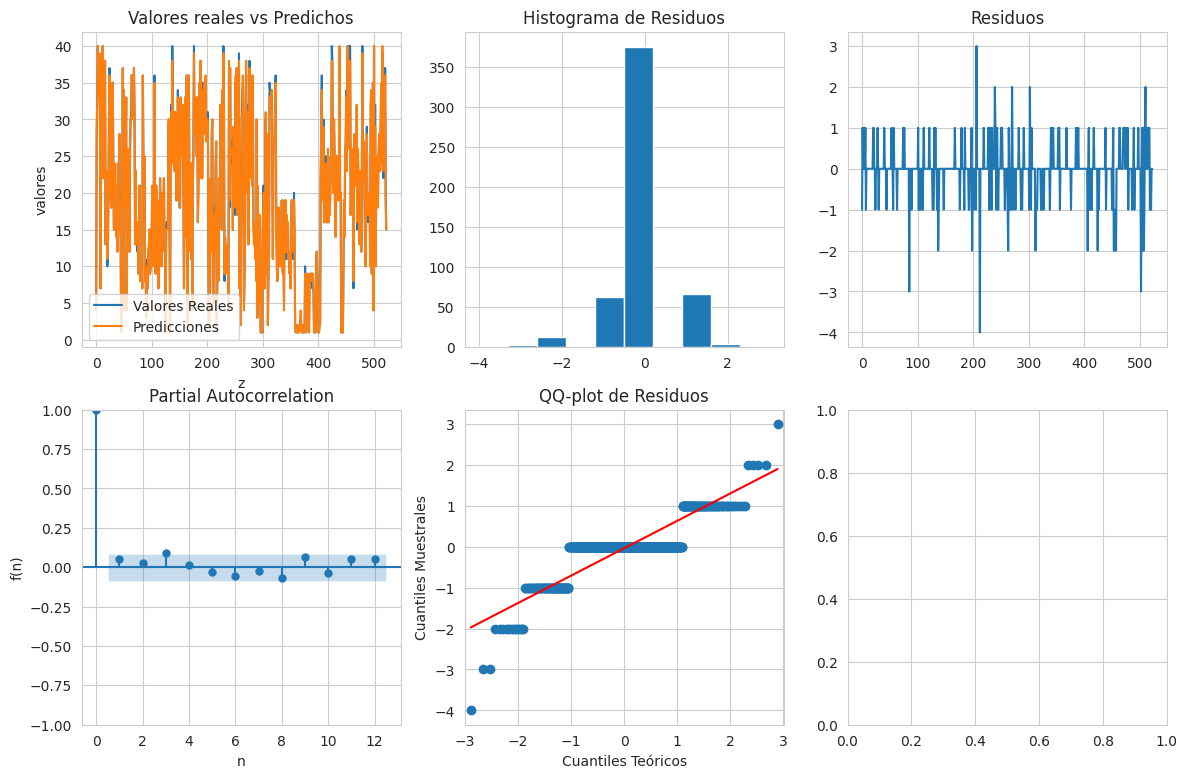

In [ ]:
fig,ax=plt.subplots(2,3);fig.set_size_inches(14,9);
sub =  []
for i in pred:
  sub.append(float(i[0]))
pred = sub
y1 = list(pred); y2 = list(menores.y_test['Demanda_Max_Estimada']);
residuos_knn = [ ]
for index,(uno, dos) in enumerate(zip(y1, y2)):
      residuos_knn.append(uno - dos)
data = pd.DataFrame({
    'Predicciones': y1,
    'Valores Reales': y2,
    'residuos': residuos_knn
})
ax[0][0].set_title('Valores reales vs Predichos')
ax[0][0].plot(data[ 'Valores Reales'],'-')
ax[0][0].plot(data['Predicciones'],'-')
ax[0][0].legend(['Valores Reales', 'Predicciones'])
ax[0][0].set_ylabel('valores')
ax[0][0].set_xlabel('z')
plot_pacf(residuos_knn, lags=12, ax=ax[1][0])
ax[1][0].set_ylabel('f(n)')
ax[1][0].set_xlabel('n')
ax[0][1].set_title('Histograma de Residuos')
ax[0][1].hist(data['residuos'])
sm.qqplot(data['residuos'], line='s', ax=ax[1][1])
ax[1][1].set_title('QQ-plot de Residuos')
ax[1][1].set_xlabel('Cuantiles Teóricos')
ax[1][1].set_ylabel('Cuantiles Muestrales')
ax[0][2].plot(data['residuos'])
ax[0][2].set_title('Residuos')

### Entrenamiento por periodo

In [ ]:
knn = training( data = mayores, parameters = [1], regressor = 'knn')
pred = knn.predict(mayores.X_test.drop('Periodo',axis='columns'))
pd.DataFrame(calcular_metricas(mayores.y_test, pred))

,RMSE,MAPE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,49.603508,1.519507,0.917215,6.406942e-09,0.0


# Ridge

In [ ]:
training_accuracy = []
test_accuracy = []
best_score = 0
tuple_scores = None
alphas = [0.01, 0.1, 1, 10, 100]
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(menores.X_train.drop('Periodo',axis='columns'), menores.y_train)
    training_accuracy.append(ridge.score(menores.X_train.drop('Periodo',axis='columns'), menores.y_train))
    test_accuracy.append(ridge.score(menores.X_test.drop('Periodo',axis='columns'), menores.y_test))
    scores = [(ridge.score(menores.X_train.drop('Periodo',axis='columns'), menores.y_train)), ridge.score(menores.X_test.drop('Periodo',axis='columns'), menores.y_test) ]
    score = np.mean(scores)
    if score > best_score:
        best_score = score
        tuple_scores = (scores[0], scores[1])
        best_parameters = {'alpha': alpha}
dx = {}
dx["Best cross-validation accuracy:"] = [best_score]
dx["Best parameters:"] = [best_parameters]
dx["Tuple Scores"] = [tuple_scores]
pd.DataFrame(dx)

,Best cross-validation accuracy:,Best parameters:,Tuple Scores
0,0.822922,{'alpha': 0.01},"(0.8170508706694307, 0.8287935210043863)"


In [ ]:
ridge =  Ridge(alpha=best_parameters['alpha'])
ridge.fit(menores.X_train.drop('Periodo',axis='columns'), menores.y_train)
pred = ridge.predict(menores.X_test.drop('Periodo',axis='columns'))
pd.DataFrame(calcular_metricas(menores.y_test, pred))

,RMSE,MAPE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,4.404499,-26.083763,0.828794,1.047324e-19,1.538209e-44


Text(0.5, 1.0, 'Residuos')

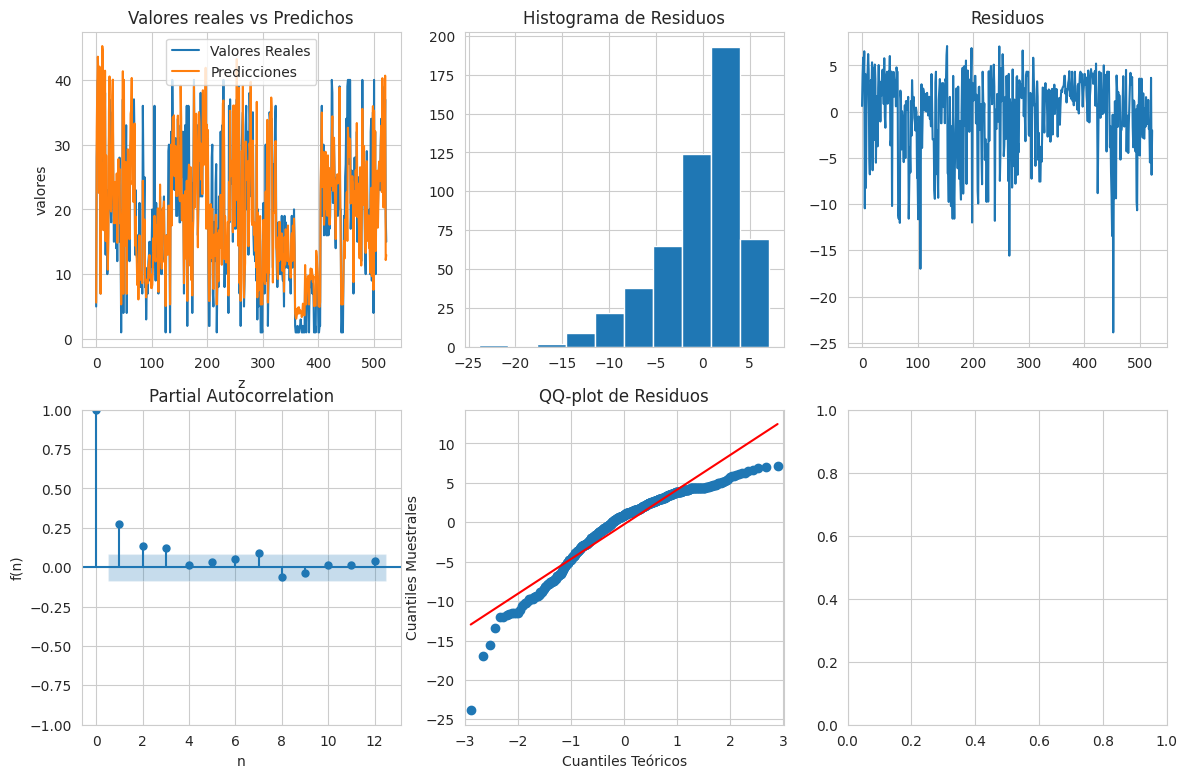

In [ ]:
fig,ax=plt.subplots(2,3);fig.set_size_inches(14,9);
sub =  []
for i in pred:
  sub.append(float(i[0]))
pred = sub
y1 = list(pred)
y2 = list(menores.y_test['Demanda_Max_Estimada']);
residuos_knn = [ ]
for index,(uno, dos) in enumerate(zip(y1, y2)):
      residuos_knn.append(uno - dos)
data = pd.DataFrame({'Predicciones': y1, 'Valores Reales': y2, 'residuos': residuos_knn})
ax[0][0].set_title('Valores reales vs Predichos')
ax[0][0].plot(data[ 'Valores Reales'],'-')
ax[0][0].plot(data['Predicciones'],'-')
ax[0][0].legend(['Valores Reales', 'Predicciones'])
ax[0][0].set_ylabel('valores')
ax[0][0].set_xlabel('z')
plot_pacf(residuos_knn, lags=12, ax=ax[1][0])
ax[1][0].set_ylabel('f(n)')
ax[1][0].set_xlabel('n')
ax[0][1].set_title('Histograma de Residuos')
ax[0][1].hist(data['residuos'])
sm.qqplot(data['residuos'], line='s', ax=ax[1][1])
ax[1][1].set_title('QQ-plot de Residuos')
ax[1][1].set_xlabel('Cuantiles Teóricos')
ax[1][1].set_ylabel('Cuantiles Muestrales')
ax[0][2].plot(data['residuos'])
ax[0][2].set_title('Residuos')

## Lasso

In [ ]:
training_accuracy = [ ]
test_accuracy     = [ ]
best_score        = 0
tuple_scores      = None
alphas = [0.01, 0.1, 1, 10, 100]
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(menores.X_train.drop('Periodo',axis='columns'), menores.y_train)
    training_accuracy.append(lasso.score(menores.X_train.drop('Periodo',axis='columns'), menores.y_train))
    test_accuracy.append(lasso.score(menores.X_test.drop('Periodo',axis='columns'), menores.y_test))
    scores = [(lasso.score(menores.X_train.drop('Periodo',axis='columns'), menores.y_train)), lasso.score(menores.X_test.drop('Periodo',axis='columns'), menores.y_test) ]
    score = np.mean(scores)
    if score > best_score:
        best_score = score
        tuple_scores = (scores[0], scores[1])
        best_parameters = {'alpha': alpha}
dx = {}
dx["Best cross-validation accuracy:"] = [best_score]
dx["Best parameters:"] = [best_parameters]
dx["Tuple Scores"] = [tuple_scores]
pd.DataFrame(dx)

,Best cross-validation accuracy:,Best parameters:,Tuple Scores
0,0.822887,{'alpha': 0.01},"(0.8170507350098893, 0.8287222969720938)"


In [ ]:
lasso =  Lasso(alpha=best_parameters['alpha'])
lasso.fit(mayores.X_train.drop('Periodo',axis='columns'), mayores.y_train)
pred = lasso.predict(mayores.X_test.drop('Periodo',axis='columns'))
pd.DataFrame(calcular_metricas(list(mayores.y_test['Demanda_Max_Estimada']), list(pred)))

,RMSE,MAPE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,52.155596,2.478529,0.908477,2.311854e-12,0.0


In [ ]:
len(y2)

523

Text(0.5, 1.0, 'Residuos')

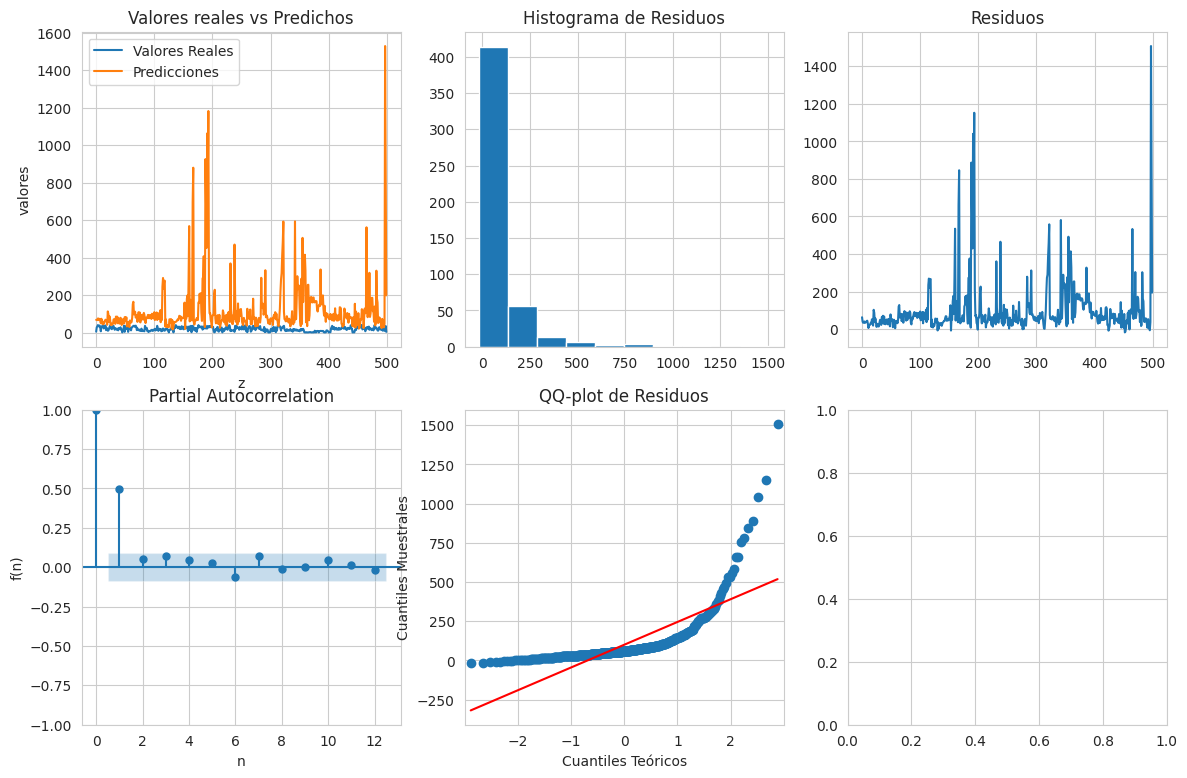

In [ ]:
fig,ax=plt.subplots( 2, 3 )
fig.set_size_inches(14,9)
sub =  []
for i in pred:
  sub.append(float(i))
pred = sub
y1 = list(pred)
y2 = list(menores.y_test['Demanda_Max_Estimada']);
residuos_knn = [ ]
for index,(uno, dos) in enumerate(zip(y1, y2)):
      residuos_knn.append(uno - dos)
data = pd.DataFrame({'Predicciones': y1, 'Valores Reales': y2[:500], 'residuos': residuos_knn})
ax[0][0].set_title('Valores reales vs Predichos')
ax[0][0].plot(data[ 'Valores Reales'],'-')
ax[0][0].plot(data['Predicciones'],'-')
ax[0][0].legend(['Valores Reales', 'Predicciones'])
ax[0][0].set_ylabel('valores')
ax[0][0].set_xlabel('z')
plot_pacf(residuos_knn, lags=12, ax=ax[1][0])
ax[1][0].set_ylabel('f(n)')
ax[1][0].set_xlabel('n')
ax[0][1].set_title('Histograma de Residuos')
ax[0][1].hist(data['residuos'])
sm.qqplot(data['residuos'], line='s', ax=ax[1][1])
ax[1][1].set_title('QQ-plot de Residuos')
ax[1][1].set_xlabel('Cuantiles Teóricos')
ax[1][1].set_ylabel('Cuantiles Muestrales')
ax[0][2].plot(data['residuos'])
ax[0][2].set_title('Residuos')